# **Homework 4: Variational Autoencoders**

### NAME: Pouya Khani

### STD_ID: 99210283

### **Goal**

This homework focuses on creating variational autoencoders applied to the MNIST dataset.

##**(NOTE: THESE ARE JUST GUIDELINES. YOU ARE NOT REQUIRED TO EXACTLY FOLLOW THIS FORMAT)**


### **Part 1 - Datasets and Dataloaders**

**Create a directory named hw4_data with the following command.**

In [1]:
!mkdir hw4_data


**Now use `torch.datasets.MNIST` to load the Train and Test data into `hw4_data`.** 
* ** Use the directory you created above as the `root` directory for your datasets**
* ** Populate the `transformations` variable with any transformations you would like to perform on your data.** (Hint: You will need to do at least one)
* **Pass your `transformations` variable to `torch.datasets.MNIST`. This allows you to perform arbitrary transformations to your data at loading time.**

In [2]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
transformations = transforms.ToTensor()
mnist_train = datasets.MNIST('../data',train=True , download=True,transform=transformations)
mnist_test = datasets.MNIST('../data',train=False , download=True,transform=transformations)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Any file in our dataset will now be read at runtime, and the specified transformations we need on it will be applied when we need it.**. 

We could iterate through these directly using a loop, but this is not idiomatic. PyTorch provides us with this abstraction in the form of `DataLoaders`. The module of interest is `torch.utils.data.DataLoader`. 

**Use `DataLoader` to create a loader for the training set and one for the testing set**
* **Use a `batch_size` of 32 to start, you may change it if you wish.**
* **Set the `shuffle` parameter to `True`.** 

**Check that the data was loaded successfully before proceeding to the next sections. **

In [3]:
from torch.utils.data import DataLoader

## YOUR CODE HERE ##
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test,batch_size=128,shuffle=True)

## **Part 2 - Encoder and Decoders (10 points)**

In this section we will be creating the encoder and decoder for our variational autoencoder (VAE). 
VAEs work around a latent space who's dimension can be chosen by us. We will leave this as a parameter for the Encoder and Decoder classes that you will have to populate. 

Feel free to use any network architecture that you wish. Try simpler network structures like a few linear layers before trying anything more complicated. 

### For the Encoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, 28,28)**
*  **forward() should return two tensors of size latent_dim like a standard encoder of a VAE**
* **One of the tensors should correspond to the mean of the encoding and the other tensor should correspond to the variance. In practice, it is easier to model the output as the log of the variance (logvar) and we will too**

### For the Decoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, latent_dim)**
*  **forward() should return a tensor of shape (batch_size, 28,28)**
* **Make sure that the output lies in the same range as the input to the encoder **







In [4]:
import torch
from torch import nn
class Encoder(nn.Module):
  def __init__(self, in_dim,h_dim,out_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    self.l1 = nn.Linear(in_dim,h_dim)
    self.l2 = nn.Linear(h_dim,out_dim)
    self.l3 = nn.Linear(h_dim,out_dim)

  def forward(self, x):
    ## YOUR CODE HERE ##
    x = torch.nn.functional.relu(self.l1(x.view(-1,28*28)))
    mu = self.l2(x)
    logVar = self.l3(x)
    return mu,logVar

class Decoder(nn.Module):
  def __init__(self, in_dim , h_dim , out_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    self.l1 = nn.Linear(out_dim,h_dim)
    self.l2 = nn.Linear(h_dim,in_dim)
    self.out_dim = out_dim
    
  def forward(self,x):
    ## YOUR CODE HERE ##
    x = torch.nn.functional.relu(self.l1(x.view(-1,self.out_dim)))
    return torch.sigmoid(self.l2(x))

## **Part 3: Training and loss functions** (5 points)

Recall that the encoder outputs the mean (mu) and the log of the variance (logvar). This implies that the latent vector of the input image follows a gaussian distribution with mean (mu) and standard deviation (e^[0.5\*logvar]). To decode this information, the decoder needs a sample from this distribution. 

**Complete the sample function to generate these samples **

In [5]:
from torch.autograd import Variable
def sample(argument):
  ## YOUR CODE HERE ##
  mu,logVar = argument
  epsilon = Variable(torch.randn(mu.size()))
  return mu + torch.exp(logVar/2)*epsilon

We also need to create the loss function. Assume that x are your input images and x_hat are your reconstructions of these input images, complete the following loss for a VAE. (Hint: You will need to use mu and logvar as well)

In [6]:
def vae_loss(x, x_hat, mu, logVar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
  loss = torch.nn.functional.binary_cross_entropy(x_hat,x.view(-1,784),reduction='sum')
  lamda = -1*0.5 * torch.sum(1+logVar-mu.pow(2)-logVar.exp())
  return loss , lamda

In the following we will instantiate an Encoder and Decoder with a latent dimension of 32.

We also define a single optimizer that optimizes the parameters of both the Encoder and the Decoder together. Feel free to use any optimizer of your choice. 

In [7]:
from torch import optim

class VAE(nn.Module):
  def __init__(self,in_dim,h_dim,out_dim):
    super(VAE,self).__init__()
    self.encoder = Encoder(in_dim,h_dim,out_dim)
    self.decoder = Decoder(in_dim,h_dim,out_dim)

  def forward(self,x):
    mu , logVar = self.encoder(x)
    out = sample([mu,logVar])
    return self.decoder(out),mu,logVar

Complete the train function that takes input encoder, decoder, train_loader, optimizer, and number of epochs you wish to train your model for.

Training will involve:

1.   **One epoch is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2.   **For each batch, use the encoder to generate the mu and logvar.**
3. **Sample a latent vector for each image in the batch and feed this to the decoder to generate the decoded images.**
4. **Calculate the loss function for this batch.**
5. **Now calculate the gradients for each parameter you are optimizing over. (Hint: Your loss function object can do this for you)**
6. **Update your model parameters (Hint: The optimizer comes in here)**
7. ** Set the gradients in your model to zero for the next batch.**



In [9]:
def train(train_loader, num_epochs = 1):
  vae = VAE(784,512,20)
  optimizer = optim.Adam(vae.parameters(),lr=1e-3)
  for i in range(num_epochs):
    train_loss = 0
    recons_loss = 0
    kl_loss = 0
    for batch_idx,(data,target) in enumerate(train_loader):
      data,target = Variable(data),Variable(data)
      pred,mu,logVar = vae(data)
      recons,kl = vae_loss(target,pred,mu,logVar)
      loss = recons + kl
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss = train_loss + loss.item()
      recons_loss = recons_loss + recons.item()
      kl_loss = kl_loss + kl.item()

    print(f'epoch {i}: Total Loss {train_loss / len(train_loader.dataset)}, reconstruction loss {recons_loss / len(train_loader.dataset)}, kl_loss {kl_loss / len(train_loader.dataset)}')
  return vae

Finally call train with the relevant parameters.

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand.

In [10]:
vae = train(train_loader, num_epochs = 10)

epoch 0: Total Loss 161.06134124348958, reconstruction loss 145.6122165201823, kl_loss 15.449124870936076
epoch 1: Total Loss 119.29731251627604, reconstruction loss 96.7241680501302, kl_loss 22.57314442138672
epoch 2: Total Loss 113.11840929361979, reconstruction loss 89.26602063802083, kl_loss 23.85238848063151
epoch 3: Total Loss 110.41758707682291, reconstruction loss 86.11487135416667, kl_loss 24.30271593424479
epoch 4: Total Loss 108.89195408528646, reconstruction loss 84.25628061523437, kl_loss 24.63567344156901
epoch 5: Total Loss 107.77767485351562, reconstruction loss 82.97197127278646, kl_loss 24.80570350341797
epoch 6: Total Loss 106.9628756998698, reconstruction loss 82.05155505371094, kl_loss 24.911320491536458
epoch 7: Total Loss 106.45413986002605, reconstruction loss 81.40170660807291, kl_loss 25.052433211263022
epoch 8: Total Loss 105.94653167317708, reconstruction loss 80.8578033203125, kl_loss 25.08872810872396
epoch 9: Total Loss 105.57040221354167, reconstruction 

## **Part 4: Visualizing the VAE output** (5 points)

We will look at how well the codes produced by the VAE can be interpolated. **For this section we will only use the MNIST test set. **

To create an interpolation between two images A and B, we encode both these images and generate a sample code for each of them. We now consider 7 equally spaced points in between these two sample codes giving us a total of 9 points including the samples. We then decode these images to get interpolated images in between A and B.

Complete the interpolation function below that takes a pair of images A and B and returns 9 images. (You are free to use any data structure you want to return these images)

In [11]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def create_interpolates(A, B, encoder, decoder):
  ## YOUR CODE HERE ##
  muA,logVarA = encoder(A)
  muB,logVarB = encoder(B)
  outA=sample([muA,logVarA])
  outB=sample([muB,logVarB])
  dist = (outA - outB)/8
  inter = []
  images_row = []
  for i in range(9):
    outC = outA + (dist*i)
    inter.append(outC)
  for laten in inter:
    img = decoder(laten)
    images_row.append(img)
  images = []
  for im in images_row:
    img = im.view(28,28).data.numpy()
    images.append(img)
  return images

**For 10 pairs of MNIST test images of the same digit (1 pair for "0", 1 pair for "1", etc.), selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows (1 row per digit) and 9 columns (7 interpolates + 2 selected test images) of images. **

In [12]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(len(y)):
    if y[i].item() not in similar_pairs:
      similar_pairs[y[i].item()] = []
    if len(similar_pairs[y[i].item()])<2:
      similar_pairs[y[i].item()].append(x[i])
  
  done = True
  for i in range(10):
    if i not in similar_pairs or len(similar_pairs[i])<2:
      done = False
  
  if done:
    break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i
encoder = vae.encoder
decoder = vae.decoder
## YOUR CODE HERE ##

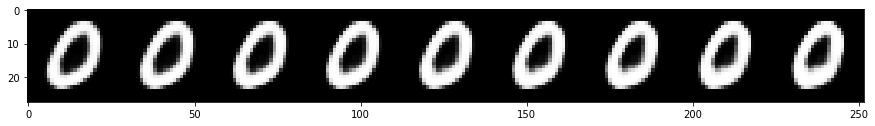

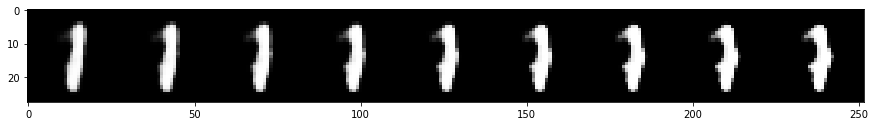

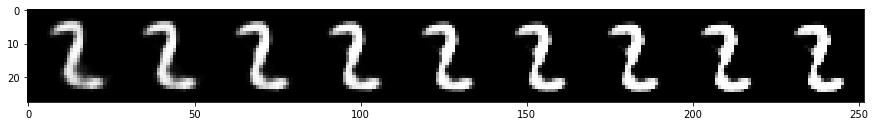

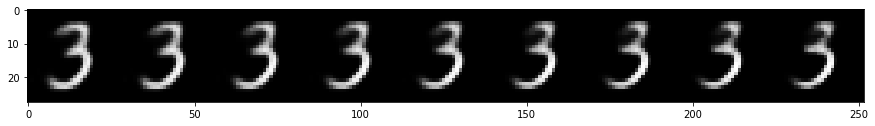

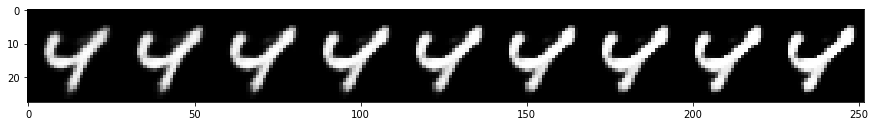

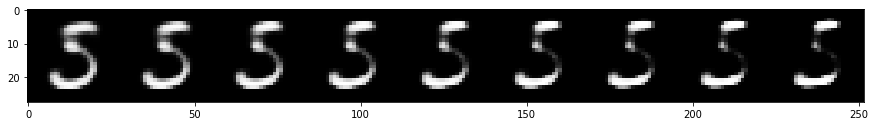

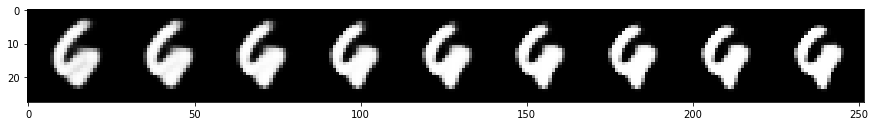

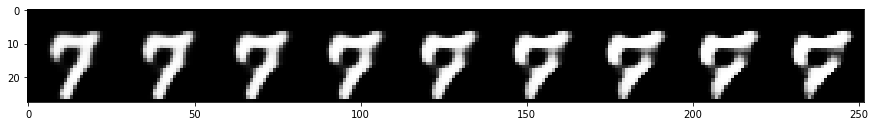

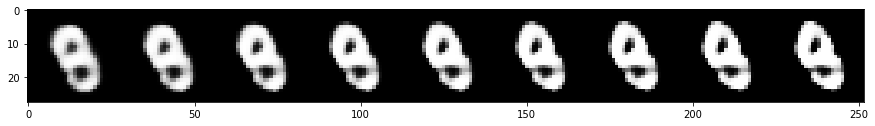

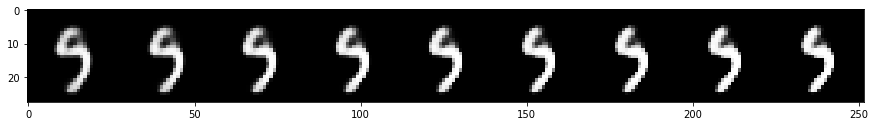

In [13]:
encoder = vae.encoder
decoder = vae.decoder
for j in range(10):
  img = create_interpolates(similar_pairs[j][0],similar_pairs[j][1],encoder,decoder) 
  plot_image = np.concatenate((img[0], img[1]), axis=1) 
  for i in range(2,9):
    plot_image = np.concatenate((plot_image, img[i]), axis=1) 
  plt.figure(figsize=(15,15))
  plt.imshow(plot_image, cmap='gray');
  plt.show()

**For 10 pairs of MNIST test images of different digits selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.**

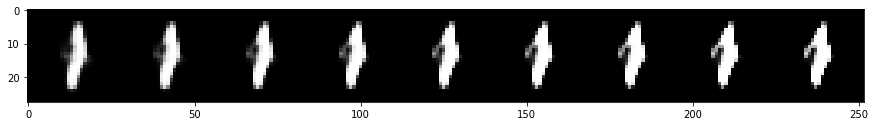

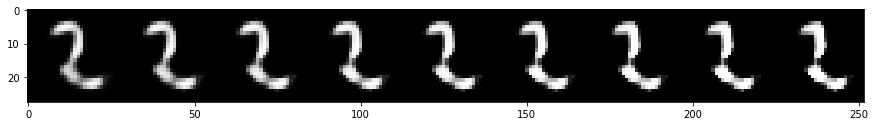

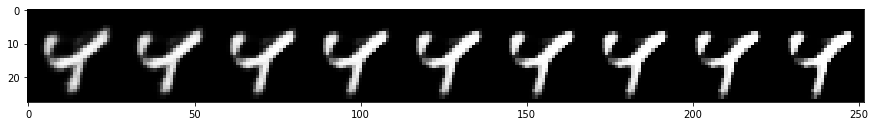

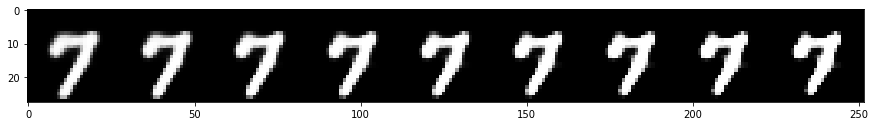

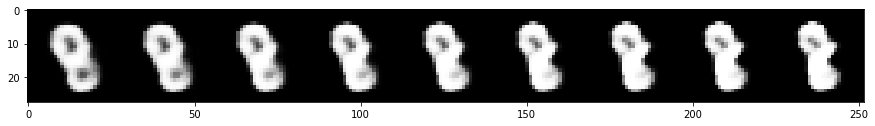

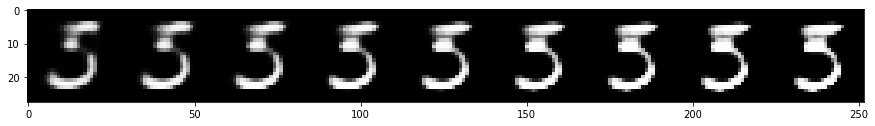

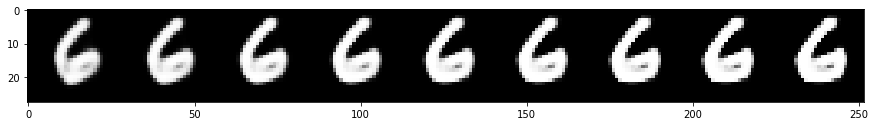

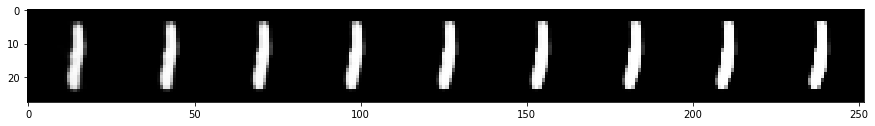

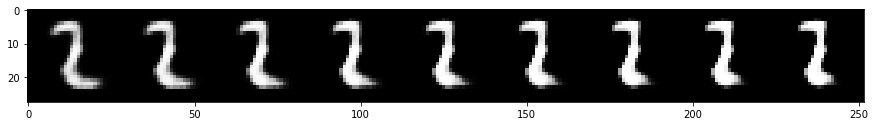

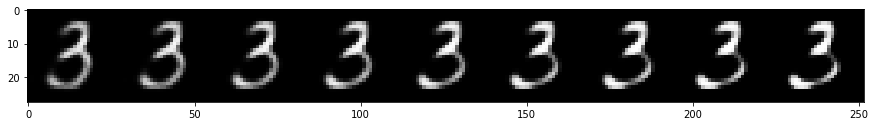

In [14]:
## YOUR CODE HERE ##
encoder = vae.encoder
decoder = vae.decoder
pair = [[1,3],[2,3],[4,6],[7,8],[8,9],[5,2],[6,7],[1,9],[2,9],[3,4]]
for j in pair:
  img = create_interpolates(similar_pairs[j[0]][0],similar_pairs[j[1]][1],encoder,decoder) 
  plot_image = np.concatenate((img[0], img[1]), axis=1) 
  for i in range(2,9):
    plot_image = np.concatenate((plot_image, img[i]), axis=1) 
  plt.figure(figsize=(15,15))
  plt.imshow(plot_image, cmap='gray');
  plt.show()